In [14]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

train = pd.read_csv("random_train0314.csv")#pd.read_csv("sorted_train0314.csv")
test = pd.read_csv("random_test0314.csv")#pd.read_csv("sorted_test0314.csv")
rand_train = pd.read_csv("random_train0314.csv")
rand_test = pd.read_csv("random_test0314.csv")

In [15]:
# Define function to calculate the relative time to a default
from datetime import datetime

def calculate_days_to_default(approval, chargeoff, terms):
    # No default occurred, return TermInMonths in days
    if pd.isnull(chargeoff):
        return terms / 12 * 365
    
    d1 = datetime.strptime(approval.split()[0], "%Y-%m-%d")
    d2 = datetime.strptime(chargeoff.split()[0], "%Y-%m-%d")
    return (d2 - d1).days

def add_relative_time_col(df):
    DaysToDefault = []
    for index, row in df.iterrows():
        approval = row["ApprovalDate"]
        chargeoff = row["ChargeOffDate"]
        terms = row['TermInMonths']
        DaysToDefault.append(calculate_days_to_default(approval, chargeoff, terms))

    df['DaysToDefault'] = pd.Series(DaysToDefault).values

    # Remove ApprovalDate, ChargeOffDate -- we no longer need these columns
#     df = df.drop(columns=["ApprovalDate", "ChargeOffDate"])

    # Convert True/False to 0/1s for Default? column
    df['Default?'] = df['LoanStatus']=='CHGOFF'
    df['Default?'] = df['Default?'].astype(int)
    return df

In [16]:
train = add_relative_time_col(train)
train.columns.tolist()

['BorrCity',
 'BorrState',
 'BorrZip',
 'CDC_City',
 'CDC_State',
 'CDC_Zip',
 'ThirdPartyLender_City',
 'ThirdPartyLender_State',
 'GrossApproval',
 'ApprovalDate',
 'ApprovalFiscalYear',
 'DeliveryMethod',
 'subpgmdesc',
 'TermInMonths',
 'ProjectCounty',
 'ProjectState',
 'BusinessType',
 'LoanStatus',
 'ChargeOffDate',
 'GrossChargeOffAmount',
 'SP500_Yearly_Return',
 'CPI',
 'Yearly_Unemployment_Rate',
 'Log_GrossApproval_Norm',
 'Log_Yearly_Unemployment_Rate_Norm',
 'Log_HPI_Norm',
 'ThirdPartyDollars_Norm',
 'TermMultipleYear',
 'RepeatBorrower',
 'BankStateneqBorrowerState',
 'ProjectStateneqBorrowerState',
 '2DigitNaics',
 'DaysToDefault',
 'Default?']

In [17]:
test = add_relative_time_col(test)

rand_train = add_relative_time_col(rand_train)
rand_test = add_relative_time_col(rand_test)

# Write these files with time duration incorporated to new files
#train.reset_index(drop=True).to_csv("output/sorted_hazard_train0314.csv", index = False)
#test.reset_index(drop=True).to_csv("output/sorted_hazard_test0314.csv", index = False)
#rand_train.reset_index(drop=True).to_csv("output/random_hazard_train0314.csv", index = False)
#rand_test.reset_index(drop=True).to_csv("output/random_hazard_test0314.csv", index = False)

In [18]:
# filtering for the columns you don't want to include for your model
c = train.columns.tolist()
c.remove('LoanStatus')
c.remove('ChargeOffDate')
c.remove('GrossChargeOffAmount')
c.remove('BorrZip')
c.remove('CDC_Zip')
c.remove('BorrCity')

c.remove('BorrState')
c.remove('CDC_State')
c.remove('ThirdPartyLender_State')
c.remove('ProjectState')

c.remove('CDC_City')
c.remove('ProjectCounty')
c.remove('ThirdPartyLender_City')
c.remove('ApprovalDate')

# Remove GrossApproval here
c.remove('GrossApproval')

print c

['ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Yearly_Unemployment_Rate', 'Log_GrossApproval_Norm', 'Log_Yearly_Unemployment_Rate_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics', 'DaysToDefault', 'Default?']


In [19]:
x_train = train[c]
print x_train.columns.tolist()
x_train = pd.get_dummies(x_train).astype(float)
print x_train.shape

x_test = test[c]
print x_test.columns.tolist()
x_test = pd.get_dummies(x_test).astype(float)
print x_test.shape

['ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Yearly_Unemployment_Rate', 'Log_GrossApproval_Norm', 'Log_Yearly_Unemployment_Rate_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics', 'DaysToDefault', 'Default?']
(43844, 53)
['ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Yearly_Unemployment_Rate', 'Log_GrossApproval_Norm', 'Log_Yearly_Unemployment_Rate_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics', 'DaysToDefault', 'Default?']
(5481, 51)


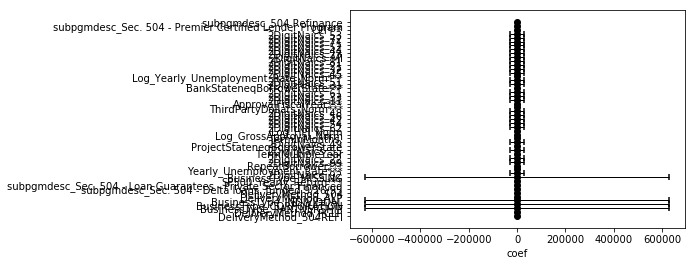

In [20]:
# hazard rate model on all loan samples
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(x_train, duration_col='DaysToDefault', event_col='Default?')

cph.plot()

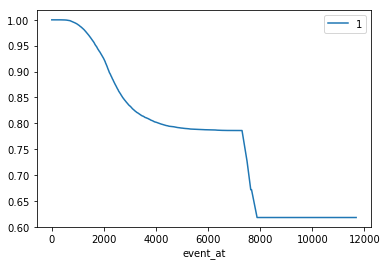

In [21]:
cph.predict_survival_function(x_train[1:2].drop(['DaysToDefault','Default?'], axis = 1)).plot()

In [22]:
# to get consistent feature dimensions for both train and test dataset
def add_missing_dummy_columns(d1, d2):
    missing_cols = set(d1.columns) - set(d2.columns)
    for c in missing_cols:
        d2[c] = 0
    return d2

print 'before fix columns: '
print x_train.shape
print x_test.shape

def fix_columns(x_train, x_test):  

    x_test = add_missing_dummy_columns(x_train, x_test)

    extra_cols = set(x_test.columns) - set(x_train.columns)
    x_test = x_test[x_train.columns]
    return x_test

x_test = fix_columns(x_train, x_test)
print 'after fix columns: '

before fix columns: 
(43844, 53)
(5481, 51)
after fix columns: 


In [23]:
print x_train.shape
print x_test.shape

(43844, 53)
(5481, 53)


In [26]:
cph.predict_survival_function(x_train[1:500].drop(['DaysToDefault','Default?'], axis = 1))

,1,2,3,4,5,6,7,8,9,10,...,490,491,492,493,494,495,496,497,498,499
event_at,,,,,,,,,,,,,,,,,,,,,
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
339.0,0.999979,0.999993,0.999990,0.999994,0.999997,0.999997,0.999977,0.999925,0.999989,0.999988,...,0.999997,0.999985,0.999939,0.999982,0.999996,0.999976,0.999968,0.999989,0.999986,0.999988
359.0,0.999958,0.999986,0.999981,0.999988,0.999995,0.999994,0.999955,0.999851,0.999979,0.999977,...,0.999994,0.999970,0.999877,0.999964,0.999992,0.999952,0.999937,0.999979,0.999973,0.999976
365.0,0.999958,0.999986,0.999981,0.999988,0.999995,0.999994,0.999955,0.999851,0.999979,0.999977,...,0.999994,0.999970,0.999877,0.999964,0.999992,0.999952,0.999937,0.999979,0.999973,0.999976
425.0,0.999937,0.999980,0.999971,0.999981,0.999992,0.999991,0.999932,0.999776,0.999968,0.999965,...,0.999991,0.999955,0.999816,0.999947,0.999988,0.999928,0.999905,0.999968,0.999959,0.999964
444.0,0.999916,0.999973,0.999961,0.999975,0.999990,0.999987,0.999909,0.999702,0.999958,0.999954,...,0.999988,0.999940,0.999755,0.999929,0.999984,0.999904,0.999874,0.999957,0.999946,0.999952
446.0,0.999895,0.999966,0.999952,0.999969,0.999987,0.999984,0.999886,0.999627,0.999947,0.999942,...,0.999985,0.999925,0.999694,0.999911,0.999980,0.999880,0.999842,0.999947,0.999932,0.999941
477.0,0.999874,0.999959,0.999942,0.999963,0.999985,0.999981,0.999864,0.999553,0.999937,0.999931,...,0.999982,0.999910,0.999632,0.999893,0.999976,0.999856,0.999810,0.999936,0.999919,0.999929
479.0,0.999853,0.999953,0.999932,0.999957,0.999982,0.999978,0.999841,0.999478,0.999926,0.999919,...,0.999980,0.999895,0.999571,0.999876,0.999972,0.999832,0.999779,0.999926,0.999905,0.999917


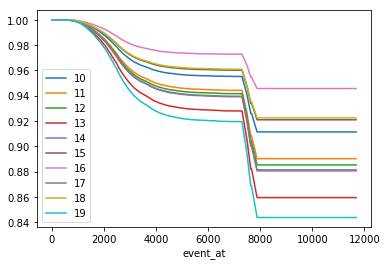

In [13]:
cph.predict_survival_function(x_test[10:20].drop(['DaysToDefault','Default?'], axis = 1)).plot()

In [25]:
# Store model
%store cph

Stored 'cph' (CoxPHFitter)


In [16]:
# Print summary
cph.print_summary()

n=43844, number of events=5340

                                                           coef     exp(coef)    se(coef)       z      p    lower 0.95   upper 0.95     
ApprovalFiscalYear                                       0.2170        1.2423      0.0121 17.9982 0.0000        0.1933       0.2406  ***
TermInMonths                                            -0.0027        0.9973      0.0005 -5.1535 0.0000       -0.0038      -0.0017  ***
SP500_Yearly_Return                                     -0.6718        0.5108      0.1073 -6.2578 0.0000       -0.8822      -0.4614  ***
CPI                                                     -0.7474        0.4736      0.4916 -1.5202 0.1285       -1.7110       0.2162     
Yearly_Unemployment_Rate                                -0.1805        0.8349      0.0822 -2.1959 0.0281       -0.3415      -0.0194    *
Log_GrossApproval_Norm                                   0.0338        1.0344      0.0153  2.2086 0.0272        0.0038       0.0639    *
Log_Yearl

In [133]:
# hazard model only on data that is death event - only on the ones that are charged off
death = train[train['LoanStatus'] == 'CHGOFF']
death = death.reset_index(drop=True)
death['Duration'] = pd.to_datetime(death['ChargeOffDate']) - pd.to_datetime(death['ApprovalDate'])
death['Observed'] = 1
death = death[c]
death.head()

,ApprovalFiscalYear,DeliveryMethod,subpgmdesc,TermInMonths,BusinessType,SP500_Yearly_Return,CPI,Log_GrossApproval_Norm,Log_HPI_Norm,ThirdPartyDollars_Norm,TermMultipleYear,RepeatBorrower,BankStateneqBorrowerState,ProjectStateneqBorrowerState,2DigitNaics,DaysToDefault,Default?
0,2004,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.120274,0.969,0.335743,0.266927,0.480989,True,0,False,False,72,1537,1
1,2004,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.120274,0.969,1.421916,0.266927,-0.377884,True,0,False,False,71,2977,1
2,2005,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.065440,1.040,-1.477124,0.454916,-0.196954,True,0,False,False,54,1848,1
3,2006,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.155040,1.081,-0.180838,1.497527,0.170356,True,0,True,False,33,2711,1
4,1999,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.305258,0.887,0.286921,-0.555141,-0.377884,True,0,False,False,MI,2909,1


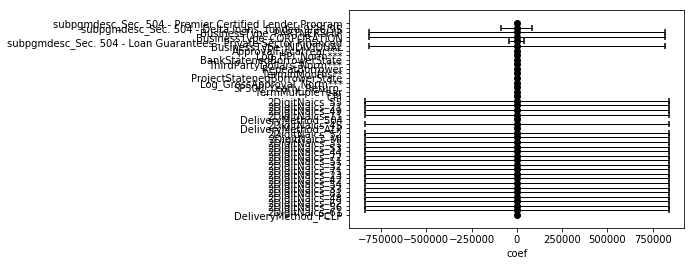

In [135]:
x_train_death = pd.get_dummies(death)

# hazard rate model on only charged off loan samples
cph = CoxPHFitter()
cph.fit(x_train_death, duration_col='DaysToDefault', event_col='Default?')

cph.plot()

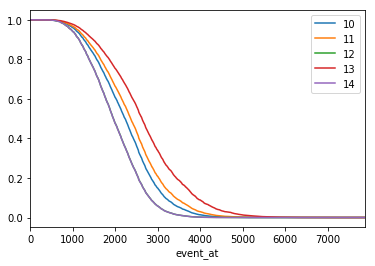

In [136]:
cph.predict_survival_function(x_train_death[10:15].drop(['DaysToDefault','Default?'], axis = 1)).plot()